In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.6 MB/s eta 0:00:00


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv('/content/DailyDelhiClimateTrain.csv')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [43]:
df.shape

(1462, 5)

In [44]:
wind_speed = df['wind_speed'].dropna()

print(f"No of missing values in the Wind Speed data: {df['wind_speed'].isnull().sum()}" )

No of missing values in the Wind Speed data: 0


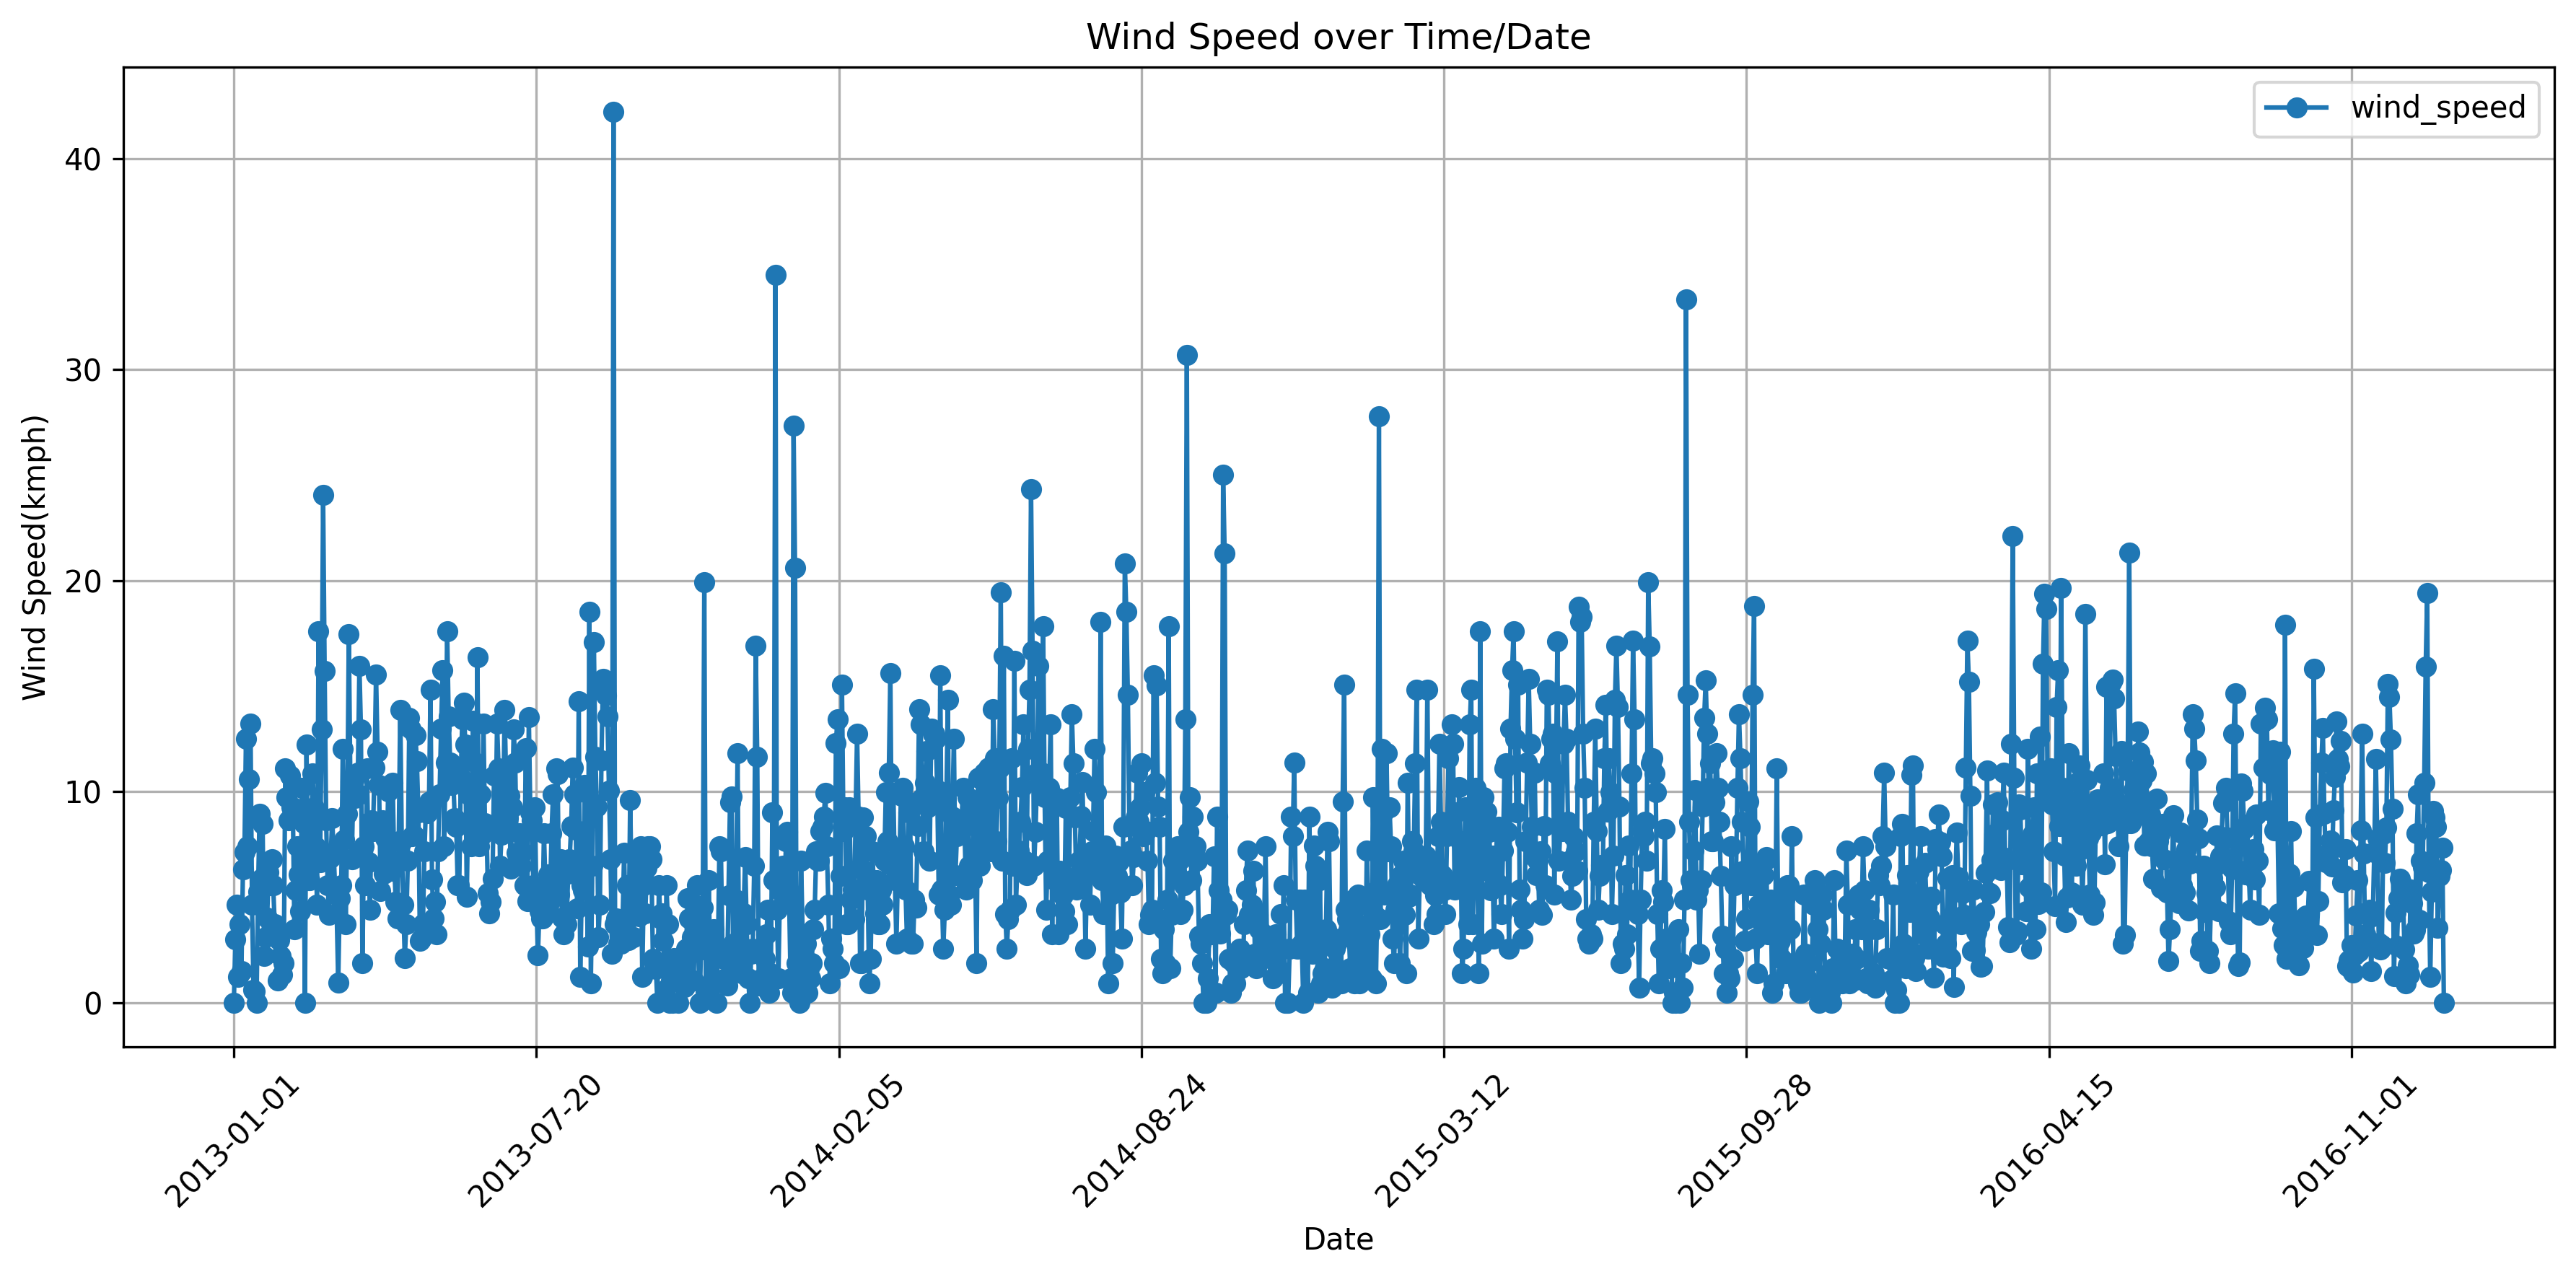

In [45]:
plt.figure(figsize=(12,6) , dpi=300)
plt.plot(df['date'], wind_speed , label = 'wind_speed', marker = 'o' )

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation = 45)

plt.xlabel('Date')
plt.ylabel('Wind Speed(kmph)')
plt.title('Wind Speed over Time/Date')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

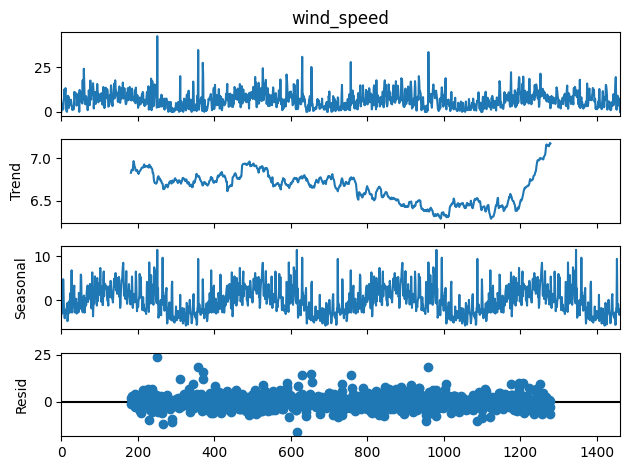

In [46]:
decomposition = seasonal_decompose(wind_speed, model='additive', period=365)

plt.figure(figsize=(12, 6))
decomposition.plot()
plt.show()

The trend shows a gradual change with a decrease at the beginning of the period and an increase towards the end. In fact, in the last few months, there is a noticeable strong rise in the average wind speed. There is a pronounced seasonal component with regular fluctuations. Outliers can be observed in the residuals, indicating rare but strong anomalous changes in wind speed.

In [47]:
#checking the stationarity of the time series
adf_result = adfuller(wind_speed)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] <= 0.05:
  print("The time series is stationary")
else:
  print("Time series is not-stationary, Differencing may required")


ADF Statistic: -3.838096756685109
p-value: 0.0025407221531463645
The time series is stationary


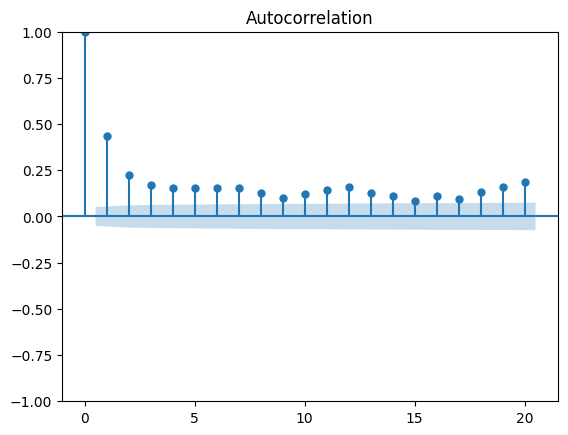

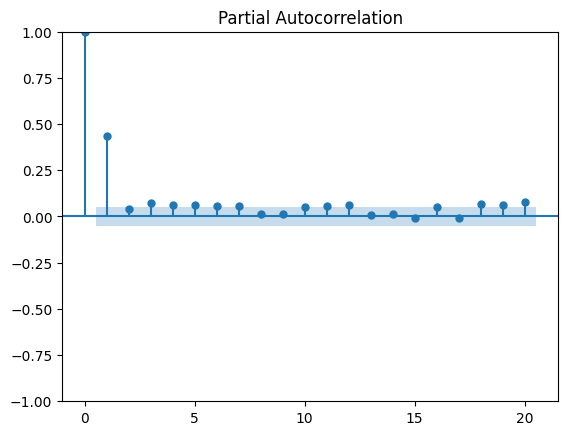

In [48]:
plot_acf(wind_speed, lags=20)
plt.show()

plot_pacf(wind_speed, lags=20)
plt.show()

In [49]:
returns = wind_speed.pct_change().dropna()*100

returns = returns[~np.isnan(returns)]
returns = returns[np.isfinite(returns)]

returns_scaled = returns * 0.1

#building and fitting grach_model
grach_model = arch_model(returns_scaled, vol='Garch' , p=1, q=1)
grach_result = grach_model.fit(disp='off')
print(grach_result.summary())

#building and fitting ARIMA_Model
arima_model = ARIMA(wind_speed, order=(1, 0, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             wind_speed   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6407.77
Distribution:                  Normal   AIC:                           12823.5
Method:            Maximum Likelihood   BIC:                           12844.6
                                        No. Observations:                 1436
Date:                Fri, Jan 31 2025   Df Residuals:                     1435
Time:                        06:40:20   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.6226      0.582      6.224  4.846e-10 [  2.482,  4.76

The GARCH model showed that the average wind speed is 3.62 km/h, and its changes over time remain almost the same, without dependence on previous values. The parameters responsible for significant variations in the data turned out to be insignificant, meaning that the model is not suitable for us.

The ARIMA model showed that wind speed data depends on previous values. The model parameters are significant, and it accurately describes the behavior of the data. Therefore, we choose ARIMA as our preferred model.v

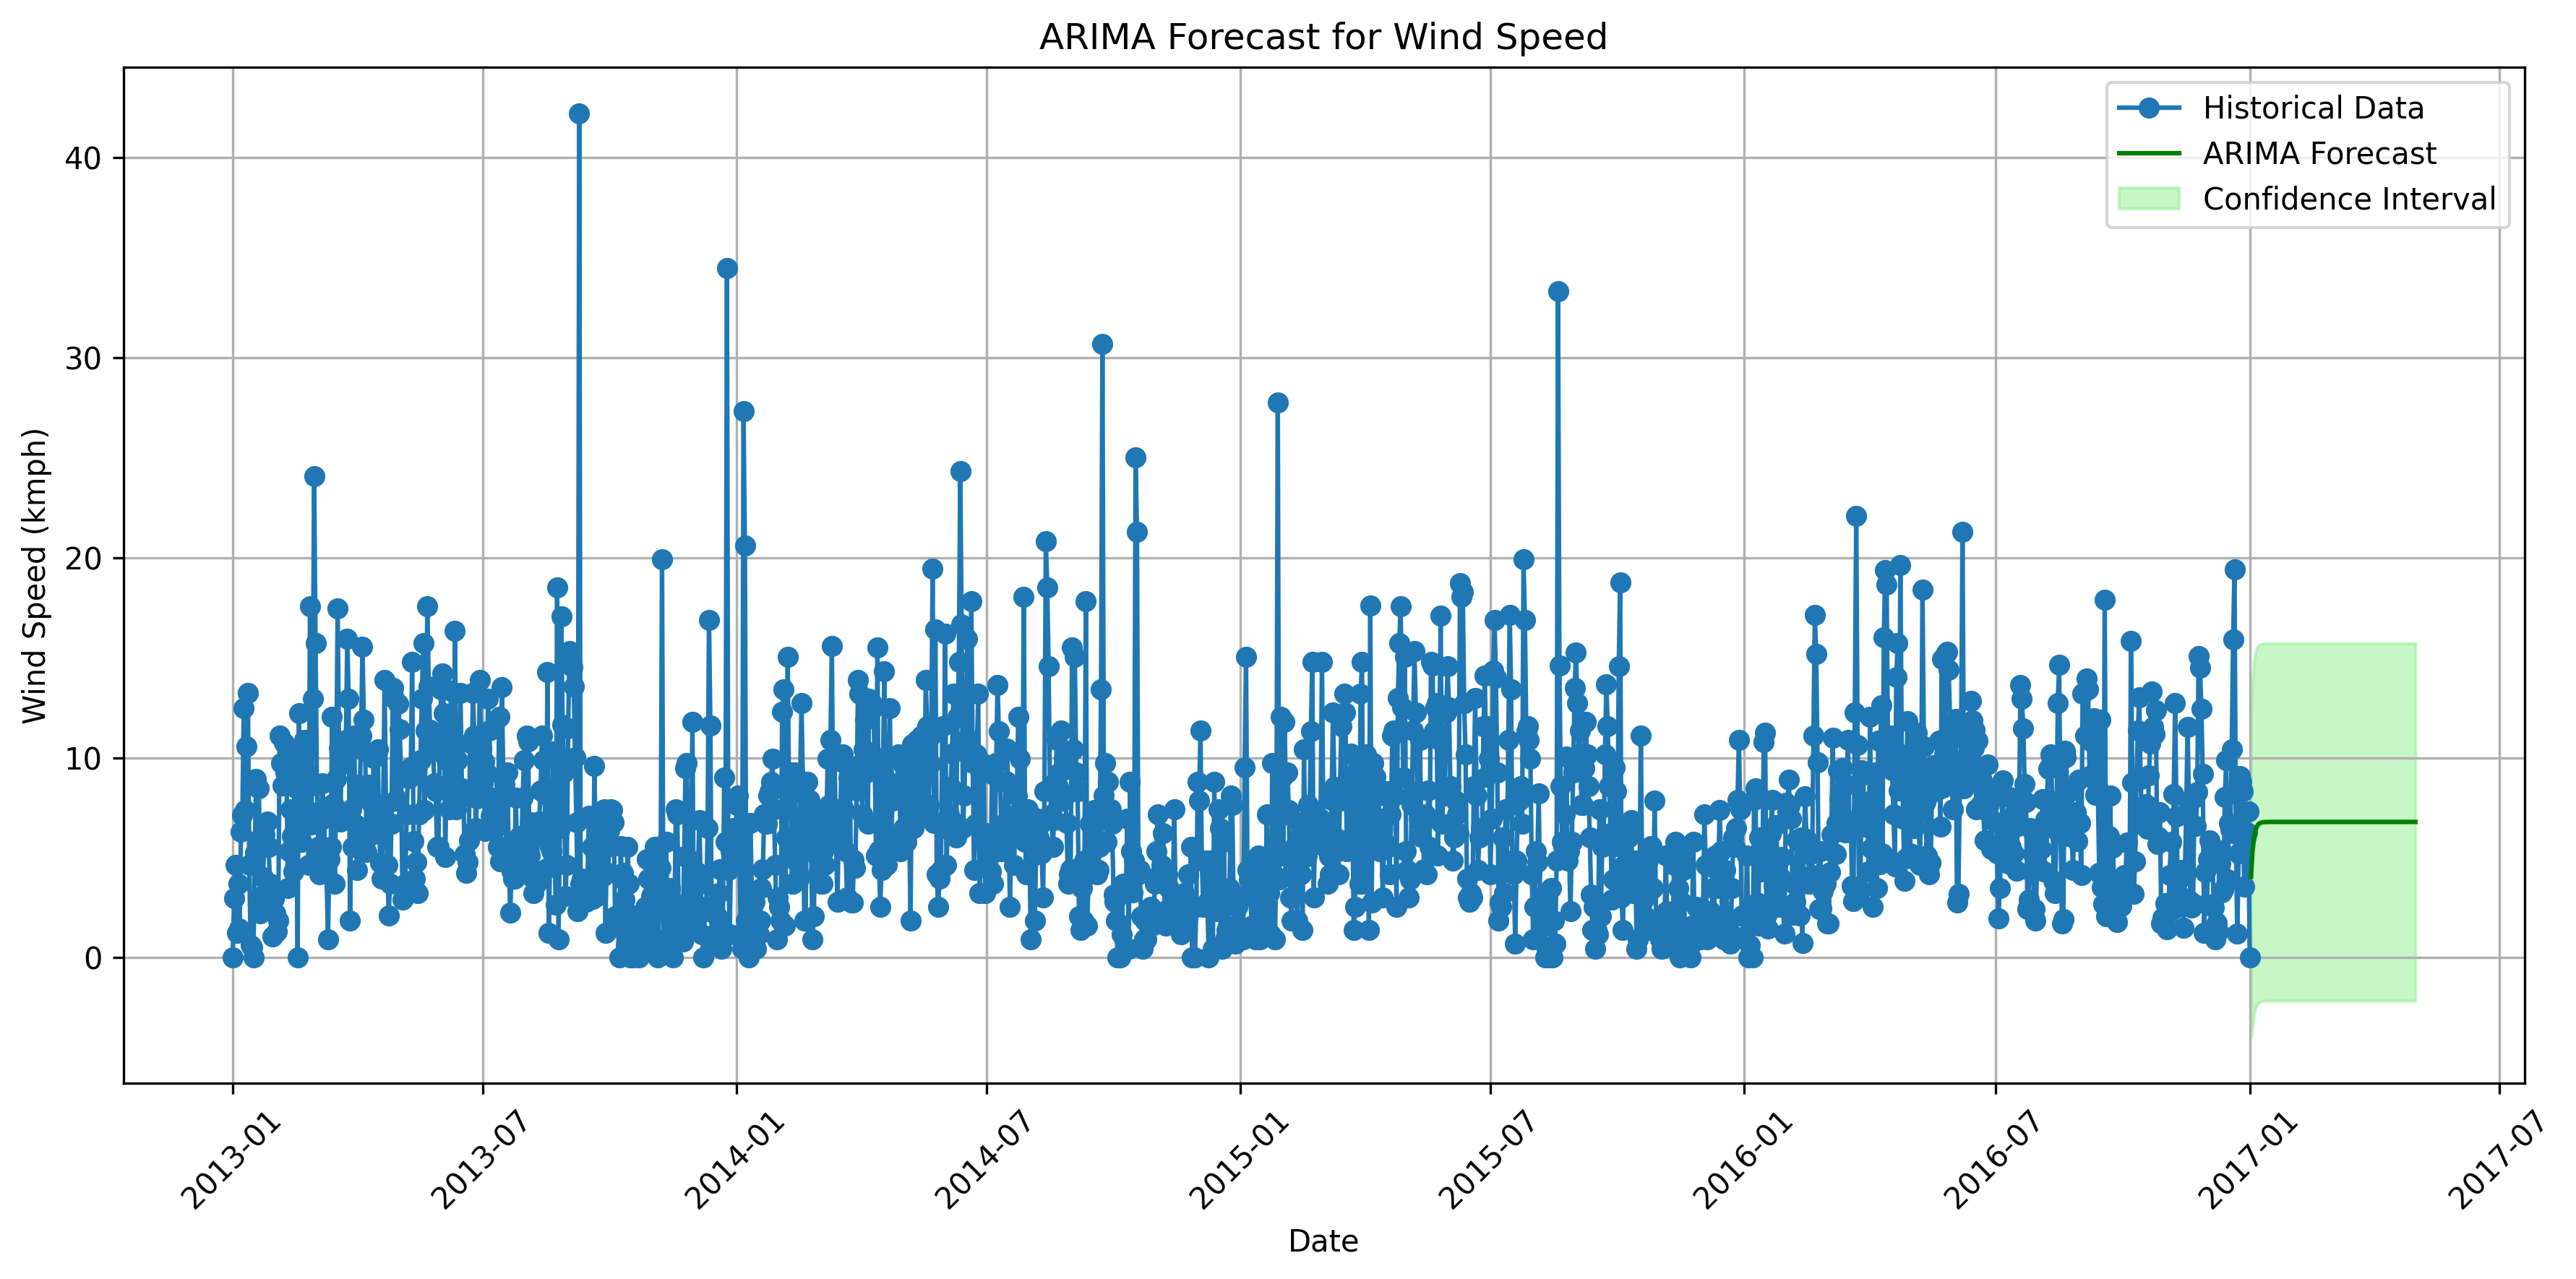

In [50]:
df['date'] = pd.to_datetime(df['date'])


df.set_index('date', inplace = True)
df = df.asfreq('D')

arima_model = ARIMA(df['wind_speed'], order=(1, 0, 1))
arima_result = arima_model.fit()


forecast_horizon = 10*12
forecast = arima_result.get_forecast(steps=forecast_horizon)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df.index, df['wind_speed'], label='Historical Data', marker='o')
plt.plot(forecast_values.index, forecast_values, label='ARIMA Forecast', color='green')
plt.fill_between(forecast_values.index,
                 forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='lightgreen', alpha=0.5, label='Confidence Interval')


plt.title('ARIMA Forecast for Wind Speed')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kmph)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()





The forecast shows that the wind speed will remain at approximately the same level as before. However, the model may not be entirely accurate, especially for long-term predictions. Overall, ARIMA is suitable for general understanding, but for a more precise forecast, it is better to consider additional factors such as seasonality or weather conditions.
